In [1]:
import numpy as np
from numpy import random
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import rel_entr
#import pickle

import genexpr
from genexpr.twostagemodel import TwoStageModel
from genexpr.threestagemodel import ThreeStageModel

In [2]:
def KL_div(P, Q):
    """
    Kullback-Leibler divergence D_KL(P || Q) between discrete distributions P and Q. The lengths of P and Q must match.

    Inputs:
        - P [ndarray, shape=(N,)]: array containing p.m.f of P
        - Q [ndarray, shape=(N,)]: array containing p.m.f of Q
            
    Outputs: 
        - D_KL [float]: Kullback-Leibler divergence D_KL(P || Q)
    """

    if len(P) != len(Q):
        return np.inf
    if not(isinstance(P, np.ndarray) and isinstance(Q, np.ndarray)):
        P, Q = np.asarray(P), np.asarray(Q)

    return np.sum(rel_entr(P,Q))


# Part 1: Simulation of paper results
## Two-stage model

- $a = \nu_0 / d_1$
- $b = \nu_1 / d_0$
- $\gamma = d_0 / d_1$
- $\tau = d_1 t$

In [3]:
twostage = TwoStageModel()

In [ ]:
# initializations
t = 0.0
x = np.array([0,0])

nu0, d0, nu1, d1 = 1, 0.1, 1, 0.1
args = [nu0, d0, nu1, d1]


# Gillespie iterations
tstat=2.0e3
(m_t, n_t), t_t = twostage.Gillespie_simulation(x, t, tstat, 10000, args, keep_transient=True)


# Mean field solution
m_MF_t, n_MF_t = twostage.mean_field_prediction(np.array([0,0]), t_t, args)


# plots
fig, ax = plt.subplots(1,1, figsize=(12,8))
ax.plot(t_t, m_t, label="mRNA m(t)")
ax.plot(t_t, m_MF_t, "--", color="C0", label="MF m(t)")
ax.plot(t_t, n_t, label="proteins n(t)")
ax.plot(t_t, n_MF_t, "--", color="C1", label="MF n(t)")

ax.set_title("Simulation of the two stage model with\n" + fr"$\nu_0$={nu0}, $d_0$={d0}, $\nu_1$={nu1}, $d_1$={d1}", fontsize=20)
ax.set_xlabel("t", fontsize=15)
ax.set_ylabel("Population", fontsize=15)
ax.legend()

### Figure 1B


In [ ]:
# gamma = 1.0
gamma, a, b, d1 = 1.0, 20.0, 2.5, 5e-4
args = (a*d1, gamma*d1, b*gamma*d1, d1)
tstat = 10.0/d1
(_, n_hist), _ = twostage.Gillespie_simulation(np.array([0,0]), 0, tstat, Nsim=100000, args=args, dt=0.01/d1, keep_transient=False)
h_, n_, _ = plt.hist(n_hist, bins=np.arange(start=-0.5, stop=max(n_hist)+0.5, step=1), density=True, label=rf"$\gamma = ${gamma}", alpha=0.7)
max_n = max(n_hist)

# gamma = 10.0
gamma, a, b, d1 = 10.0, 20.0, 2.5, 5e-4
args = (a*d1, gamma*d1, b*gamma*d1, d1)
tstat = 10.0/d1
(_, n_hist), _ = twostage.Gillespie_simulation(np.array([0,0]), 0, tstat, Nsim=100000, args=args, dt=0.01/d1, keep_transient=False)
h_, n_, _ = plt.hist(n_hist, bins=np.arange(start=-0.5, stop=max(n_hist)+0.5, step=1), density=True, label=rf"$\gamma = ${gamma}", alpha=0.7)
max_n = max(max_n, max(n_hist))


# analytical plot
n0 = np.arange(max_n+30)
fn_analytical = twostage.analytical_stationary(n0, args, normalize=True)
plt.plot(n0, fn_analytical, "--", c="black", label="analytical")
plt.title("Simulation of the two stage model with\n" + fr"$a$={a}, $b$={b}, $d_1$={d1}", fontsize=20)
plt.legend()

### Figure 1C


In [ ]:
# gamma = 1.0
gamma, a, b, d1 = 1.0, 0.5, 100.0, 5e-4
args = (a*d1, gamma*d1, b*gamma*d1, d1)
tstat = 10.0/d1
(_, n_hist), _ = twostage.Gillespie_simulation(np.array([0,0]), 0, tstat, Nsim=100000, args=args, dt=0.01/d1, keep_transient=False)
h_, n_, _ = plt.hist(n_hist, bins=np.arange(start=-0.5, stop=max(n_hist)+0.5, step=1), density=True, label=rf"$\gamma = ${gamma}", alpha=0.7)
max_n = max(n_hist)

# gamma = 10.0
gamma, a, b, d1 = 10.0, 0.5, 100.0, 5e-4
args = (a*d1, gamma*d1, b*gamma*d1, d1)
tstat = 10.0/d1
(_, n_hist), _ = twostage.Gillespie_simulation(np.array([0,0]), 0, tstat, Nsim=100000, args=args, dt=0.01/d1, keep_transient=False)
h_, n_, _ = plt.hist(n_hist, bins=np.arange(start=-0.5, stop=max(n_hist)+0.5, step=1), density=True, label=rf"$\gamma = ${gamma}", alpha=0.7)
max_n = max(max_n, max(n_hist))


# analytical plot
n0 = np.arange(max_n+30)
fn_analytical = twostage.analytical_stationary(n0, args, normalize=True)
plt.plot(n0, fn_analytical, "--", c="black", label="analytical")
plt.xlim(-1,150)
plt.title("Simulation of the two stage model with\n" + fr"$a$={a}, $b$={b}, $d_1$={d1}", fontsize=20)
plt.legend()

### Figure 1D

In [ ]:
gammas = np.logspace(-2, 2, num=15, base=10)
args_ = [(20.0, 2.5, 5e-4), (0.5, 100.0, 5e-4)]
res = {}

for arg_ in args_:
    res[f"{arg_[0]}_{arg_[1]}"] = {"D_KL":[], "gamma":[]}

    for gamma_ in gammas:
        a_, b_, d1_ = arg_
        args = (a_*d1_, gamma_*d1_, b_*gamma_*d1_, d1_)
        tstat_ = 10.0/d1_

        (_, n_hist), _ = twostage.Gillespie_simulation(np.array([0,0]), 0, tstat, Nsim=100000, args=args, dt=0.01/d1, keep_transient=False)
        h_, n_, _ = plt.hist(n_hist, bins=np.arange(start=-0.5, stop=max(n_hist)+0.5, step=1), density=True)
        n0 = np.arange(len(h_)+30)
        fn_analytical = twostage.analytical_stationary(n0, args, normalize=True)
        plt.clf()

        res[f"{arg_[0]}_{arg_[1]}"]["D_KL"].append(KL_div(h_, fn_analytical[:len(h_)]))
        res[f"{arg_[0]}_{arg_[1]}"]["gamma"].append(gamma_)

In [ ]:
for (a_,b_,_) in args_:
    data = res[f"{a_}_{b_}"]
    plt.plot(data["gamma"], data["D_KL"], "*--", label=f"a={a_}, b={b_}")
plt.xscale("log")
plt.xlabel("$\gamma$")
plt.legend()

### Figure 2A

In [ ]:
gamma, a, b, d1 = 10.0, 20.0, 2.5, 5e-4
args = (a*d1, gamma*d1, b*gamma*d1, d1)
tslice = np.array([0.01, 0.2, 0.8, 2, 10]) / d1

(_, n_hist) = twostage.Gillespie_simulation_transient(np.array([0,0]), 0, tslice, Nsim=1000, args=args)

In [ ]:
for t_, n_t in enumerate(n_hist):
    plt.hist(n_t, bins=np.arange(start=-0.5, stop=max(n_t)+0.5, step=1), density=True, alpha=0.5, label=f"$t\, d_1 = ${np.round(tslice[t_]*d1, 2)}")

    n0 = np.arange(max(n_t))
    plt.plot(n0, twostage.analytical_transient(n0, tslice[t_], np.identity(1)[0,:], args=args, normalize=True), ls="-", c="C"+str(t_))

plt.title("Simulation of the two stage model with\n" + fr"$a$={a}, $b$={b}, $d_1$={d1}, $\gamma$={gamma}", fontsize=20)
plt.ylim(0,0.2)
plt.legend()

### Figure 2B

In [4]:
gamma, a, b, d1 = 10.0, 0.5, 100.0, 5e-4
args = (a*d1, gamma*d1, b*gamma*d1, d1)
tslice = np.array([0.01, 0.2, 0.8, 2, 10]) / d1

(_, n_hist) = twostage.Gillespie_simulation_transient(np.array([0,50]), 0, tslice, Nsim=100, args=args)

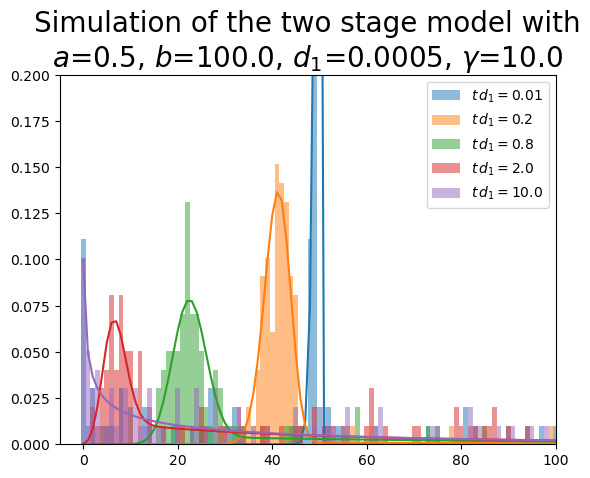

In [5]:
for t_, n_t in enumerate(n_hist):
    plt.hist(n_t, bins=np.arange(start=-0.5, stop=max(n_t)+0.5, step=1), density=True, alpha=0.5, label=f"$t\, d_1 = ${np.round(tslice[t_]*d1, 2)}")

    n0 = np.arange(max(n_t))
    plt.plot(n0, twostage.analytical_transient(n0, tslice[t_], np.identity(51)[50,:], args=args, normalize=True), c="C"+str(t_), ls="-")

plt.title("Simulation of the two stage model with\n" + fr"$a$={a}, $b$={b}, $d_1$={d1}, $\gamma$={gamma}", fontsize=20)
plt.xlim(-5, 100)
plt.ylim(0, 0.2)
plt.legend()

### Figure 2C

In [ ]:
taus = np.logspace(-2, 1, num=15, base=10)
args_ = [(10.0, 20.0, 2.5, 5e-4), (10.0, 0.5, 100.0, 5e-4)]
x0s = [np.array([0,0]), np.array([0,50])]
res = {}

for x0_, arg_ in zip(x0s, args_):
    res[f"{arg_[1]}_{arg_[2]}"] = {"D_KL":[], "tau":[]}

    for tau_ in taus:
        gamma_, a_, b_, d1_ = arg_
        args = (a_*d1_, gamma_*d1_, b_*gamma_*d1_, d1_)
        
        n_hist = twostage.Gillespie_simulation_transient(x0_, 0, np.array([tau_/d1_]), Nsim=1000, args=args)[1,0,:]
        h_, n_, _ = plt.hist(n_hist, bins=np.arange(start=-0.5, stop=max(n_hist)+0.5, step=1), density=True)
        n0 = np.arange(len(h_)+30)
        fn_analytical = twostage.analytical_transient(n0, tau_/d1_, np.identity(int(x0_[1])+1)[int(x0_[1]),:], args, normalize=True)
        plt.clf()

        res[f"{arg_[1]}_{arg_[2]}"]["D_KL"].append(KL_div(h_, fn_analytical[:len(h_)]))
        res[f"{arg_[1]}_{arg_[2]}"]["tau"].append(tau_)

In [ ]:
for (_,a_,b_,_) in args_:
    data = res[f"{a_}_{b_}"]
    plt.plot(data["tau"], data["D_KL"], "*--", label=f"a={a_}, b={b_}")
plt.xscale("log")
plt.xlabel("$\t\, d_1$")
plt.legend()

### Figure 2D

In [6]:
from scipy.special import loggamma

def NBinom(k, mu, eta):
    r = mu/(mu*eta**2 - 1)
    p = 1/(mu*eta**2)

    if p<0 or p>1 or r<0:
        return -1
    else:
        return np.exp(loggamma(k+r)-loggamma(k+1)-loggamma(r) + k*np.log(1-p) + r*np.log(p))

In [41]:
taus = np.linspace(0, 5, num=20)
gamma, a, b, d1 = 10.0, 20.0, 2.5, 5e-4
mu_ = 50
noises = np.linspace(0.2, 1.0, num=9)
eta_stat = np.sqrt((1+b)/(a*b))
res = {}

for eta_ in noises:
    res[f"eta0_{eta_}"] = {"eta":[], "tau":[]}

    for tau_ in taus:
        args = (a*d1, gamma*d1, b*gamma*d1, d1)

        n0 = np.arange(150)
        fn_analytical = twostage.analytical_transient(n0, tau_/d1, NBinom(n0, mu_, eta_), args, normalize=True)
        mean_dist = np.average(n0, weights=fn_analytical)
        std_dist = np.sqrt(np.average((n0-mean_dist)**2, weights=fn_analytical))
        plt.clf()

        res[f"eta0_{eta_}"]["eta"].append(std_dist/mean_dist)
        res[f"eta0_{eta_}"]["tau"].append(tau_)

<Figure size 640x480 with 0 Axes>

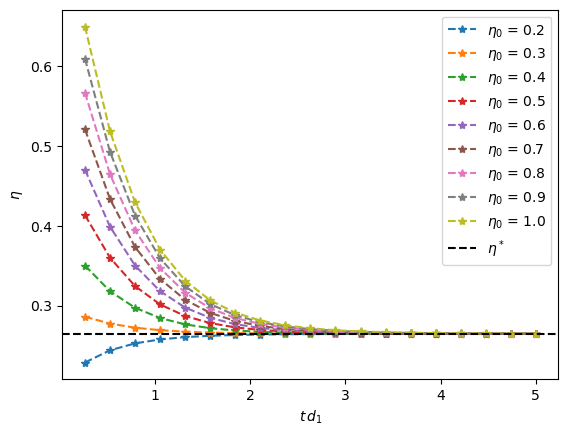

In [43]:
for eta_ in noises:
    data = res[f"eta0_{eta_}"]
    plt.plot(data["tau"], data["eta"], "*--", label=f"$\eta_0$ = {round(eta_,2)}")

plt.axhline(eta_stat, c="k", ls="--", label="$\eta^*$")
plt.xlabel("$t\, d_1$")
plt.ylabel("$\eta$")
plt.legend()

## Three-stage model
- $a = \nu_0 / d_1$
- $b = \nu_1 / d_0$
- $\gamma = d_0 / d_1$
- $\tau = d_1 t$
- $\kappa_0 = K_0/d_1$
- $\kappa_1 = K_1/d_1$

In [2]:
threestage = ThreeStageModel()

### Figure 3B

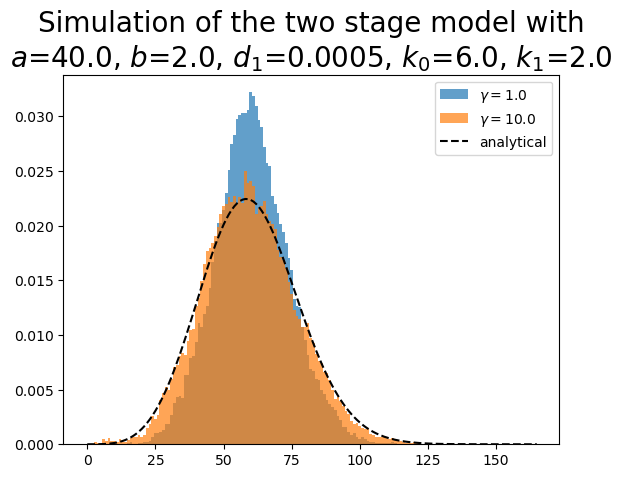

In [7]:
# gamma = 1.0
gamma, a, b, d1, k0, k1 = 1.0, 40.0, 2.0, 5e-4, 6.0, 2.0
args = (a*d1, gamma*d1, b*gamma*d1, d1, k0*d1, k1*d1)
tstat = 10.0/d1
(_, n_hist, _), _ = threestage.Gillespie_simulation(np.array([0,0,0]), 0, tstat, Nsim=100000, args=args, dt=0.01/d1, keep_transient=False)
h_, n_, _ = plt.hist(n_hist, bins=np.arange(start=-0.5, stop=max(n_hist)+0.5, step=1), density=True, label=rf"$\gamma = ${gamma}", alpha=0.7)
max_n = max(n_hist)

# gamma = 10.0
gamma, a, b, d1, k0, k1 = 10.0, 40.0, 2.0, 5e-4, 6.0, 2.0
args = (a*d1, gamma*d1, b*gamma*d1, d1, k0*d1, k1*d1)
tstat = 10.0/d1
(_, n_hist, _), _ = threestage.Gillespie_simulation(np.array([0,0,0]), 0, tstat, Nsim=100000, args=args, dt=0.01/d1, keep_transient=False)
h_, n_, _ = plt.hist(n_hist, bins=np.arange(start=-0.5, stop=max(n_hist)+0.5, step=1), density=True, label=rf"$\gamma = ${gamma}", alpha=0.7)
max_n = max(max_n, max(n_hist))


# analytical plot
n0 = np.arange(max_n+30)
fn_analytical = threestage.analytical_stationary(n0, args, normalize=True)
plt.plot(n0, fn_analytical, "--", c="black", label="analytical")
plt.title("Simulation of the two stage model with\n" + fr"$a$={a}, $b$={b}, $d_1$={d1}, $k_0$={k0}, $k_1$={k1}", fontsize=20)
plt.legend()

### Figure 3C

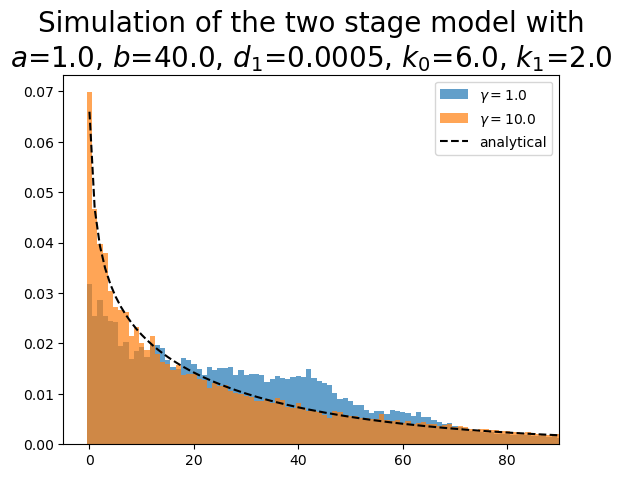

In [9]:
# gamma = 1.0
gamma, a, b, d1, k0, k1 = 1.0, 1.0, 40.0, 5e-4, 6.0, 2.0
args = (a*d1, gamma*d1, b*gamma*d1, d1, k0*d1, k1*d1)
tstat = 10.0/d1
(_, n_hist, _), _ = threestage.Gillespie_simulation(np.array([0,0,0]), 0, tstat, Nsim=100000, args=args, dt=0.01/d1, keep_transient=False)
h_, n_, _ = plt.hist(n_hist, bins=np.arange(start=-0.5, stop=max(n_hist)+0.5, step=1), density=True, label=rf"$\gamma = ${gamma}", alpha=0.7)
max_n = max(n_hist)

# gamma = 10.0
gamma, a, b, d1, k0, k1 = 10.0, 1.0, 40.0, 5e-4, 6.0, 2.0
args = (a*d1, gamma*d1, b*gamma*d1, d1, k0*d1, k1*d1)
tstat = 10.0/d1
(_, n_hist, _), _ = threestage.Gillespie_simulation(np.array([0,0,0]), 0, tstat, Nsim=100000, args=args, dt=0.01/d1, keep_transient=False)
h_, n_, _ = plt.hist(n_hist, bins=np.arange(start=-0.5, stop=max(n_hist)+0.5, step=1), density=True, label=rf"$\gamma = ${gamma}", alpha=0.7)
max_n = max(max_n, max(n_hist))


# analytical plot
n0 = np.arange(max_n+30)
fn_analytical = threestage.analytical_stationary(n0, args, normalize=True)
plt.plot(n0, fn_analytical, "--", c="black", label="analytical")
plt.title("Simulation of the two stage model with\n" + fr"$a$={a}, $b$={b}, $d_1$={d1}, $k_0$={k0}, $k_1$={k1}", fontsize=20)
plt.xlim(-5, 90)
plt.legend()

### Figure 3D

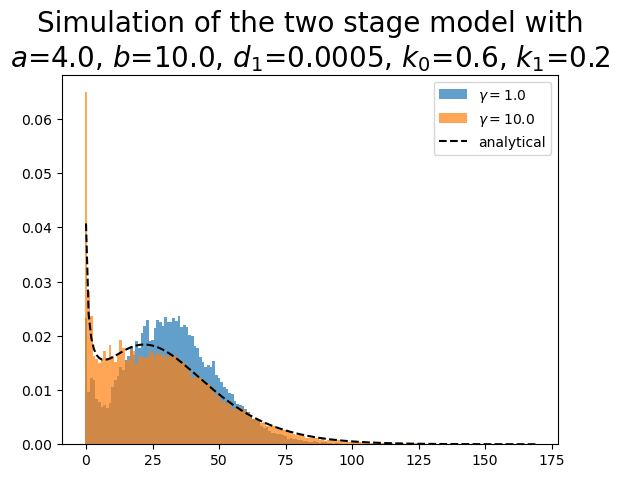

In [10]:
# gamma = 1.0
gamma, a, b, d1, k0, k1 = 1.0, 4.0, 10.0, 5e-4, 0.6, 0.2
args = (a*d1, gamma*d1, b*gamma*d1, d1, k0*d1, k1*d1)
tstat = 10.0/d1
(_, n_hist, _), _ = threestage.Gillespie_simulation(np.array([0,0,0]), 0, tstat, Nsim=100000, args=args, dt=0.01/d1, keep_transient=False)
h_, n_, _ = plt.hist(n_hist, bins=np.arange(start=-0.5, stop=max(n_hist)+0.5, step=1), density=True, label=rf"$\gamma = ${gamma}", alpha=0.7)
max_n = max(n_hist)

# gamma = 10.0
gamma, a, b, d1, k0, k1 = 10.0, 4.0, 10.0, 5e-4, 0.6, 0.2
args = (a*d1, gamma*d1, b*gamma*d1, d1, k0*d1, k1*d1)
tstat = 10.0/d1
(_, n_hist, _), _ = threestage.Gillespie_simulation(np.array([0,0,0]), 0, tstat, Nsim=100000, args=args, dt=0.01/d1, keep_transient=False)
h_, n_, _ = plt.hist(n_hist, bins=np.arange(start=-0.5, stop=max(n_hist)+0.5, step=1), density=True, label=rf"$\gamma = ${gamma}", alpha=0.7)
max_n = max(max_n, max(n_hist))


# analytical plot
n0 = np.arange(max_n+30)
fn_analytical = threestage.analytical_stationary(n0, args, normalize=True)
plt.plot(n0, fn_analytical, "--", c="black", label="analytical")
plt.title("Simulation of the two stage model with\n" + fr"$a$={a}, $b$={b}, $d_1$={d1}, $k_0$={k0}, $k_1$={k1}", fontsize=20)
plt.legend()

# Part 2: simulation with real data

In [ ]:
data = pd.read_csv("data/data_LN_PST_MB.csv")
data